PSET 3 - OEAS 895 (Alfonso, Mike, Sveinn)

This code is organized into 4 sections:
    1. Comparing the 2 datasets (JMA, Argo) and looking at overlaps and gaps.
    2. Creating models to find the best fit model for the JMA dataset, to use on the ARGO data.
    3. Use only data from JMA that corresponds to the geographic area of the ARGO dataset. Then do the same thing as in section 2.
    4. Analysis of the best fit models from sections 2 and 3, to see if using data from the same geographic area results in a better model.

In [44]:
#Import packages needed to run code
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Import the JMA dataset and visualize to see what we have

In [64]:
infile = 'jma_nitrate.csv'
data = pd.read_csv(infile, sep = (','))
#Let's take a look at the data.
#data

Text(0,0.5,'Depth (m)')

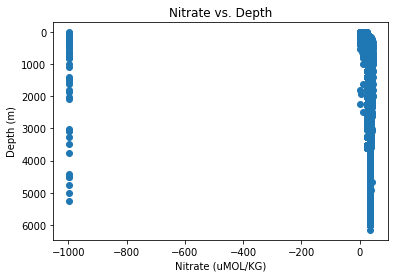

In [65]:
# Let's plot the nitrate data just to visualize what we have.
plt.scatter(data.nitrate,data.depth)
plt.gca().invert_yaxis()
plt.title('Nitrate vs. Depth')
plt.xlabel('Nitrate (uMOL/KG)')
plt.ylabel('Depth (m)')

The raw jma data appear to have some nitrate values at -999, representing either no data or bad data. These have to be removed before we can continue.

Text(0,0.5,'Depth (m)')

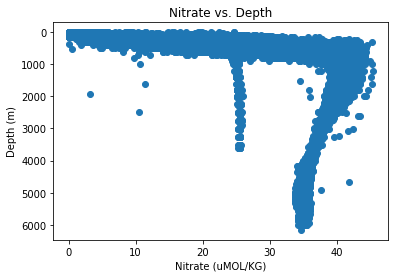

In [66]:
# Looks like there are -999 values to indicate no samples or bad samples. Let's take those out.
corr_data = data[data.nitrate>0]
plt.scatter(corr_data.nitrate,corr_data.depth)
plt.gca().invert_yaxis()
plt.title('Nitrate vs. Depth')
plt.xlabel('Nitrate (uMOL/KG)')
plt.ylabel('Depth (m)')

In [67]:
# Reading in the Argo float data with no NO3 values
infile = 'kuro_BGCargo_noNO3.csv'
data_BGC = pd.read_csv(infile, sep = (','))

# Separating the date column of BGC argo data into year month and day columns to look at seasonality compared to the jma data.
import datetime

data_BGC['year'] = pd.DatetimeIndex(data_BGC['Date/GMT']).year
data_BGC['month'] = pd.DatetimeIndex(data_BGC['Date/GMT']).month
data_BGC['day'] = pd.DatetimeIndex(data_BGC['Date/GMT']).day
#data_BGC.head()



# Section 1, compare datasets (JMA, ARGO)

Compare the samples locations and see how the datasets overlap or don't overlap

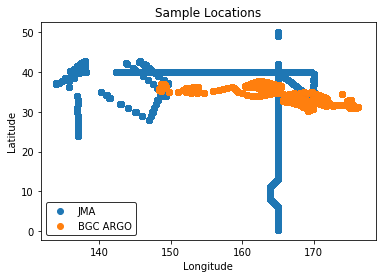

In [68]:
plt.scatter(corr_data.lon,corr_data.lat)
plt.scatter(data_BGC.LON,data_BGC.LAT)
plt.title('Sample Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(('JMA','BGC ARGO'), edgecolor='k', loc='lower left')

Compare the water masses that were sampled in both datasets

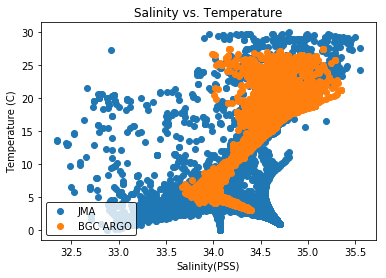

In [69]:
#Plot to look at salinity and depth comparison
plt.scatter(corr_data.sal,corr_data.theta)
plt.scatter(data_BGC['SALINITY[PSS]'],data_BGC['TEMPERATURE[C]'])
plt.title('Salinity vs. Temperature')
plt.xlabel('Salinity(PSS)')
plt.ylabel('Temperature (C)')
plt.legend(('JMA','BGC ARGO'), edgecolor='k', loc='lower left')

Compare the seasonal coverage of both datasets

Text(0,0.5,'Sample count')

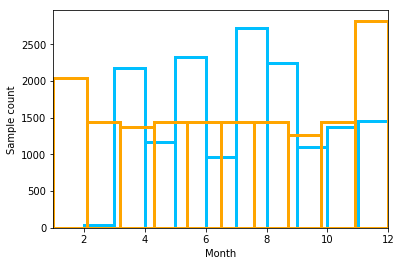

In [51]:
#Plot to look at seasonal comparison of the data

month = [0,12,1]
plt.hist(corr_data.month, facecolor = "none", edgecolor = "deepskyblue", lw = 3)
plt.hist(data_BGC['month'], facecolor = "none", edgecolor = "orange", lw = 3)
plt.xlim([1,12])
plt.xlabel("Month")
plt.ylabel("Sample count")

(2010.75, 2017.25)

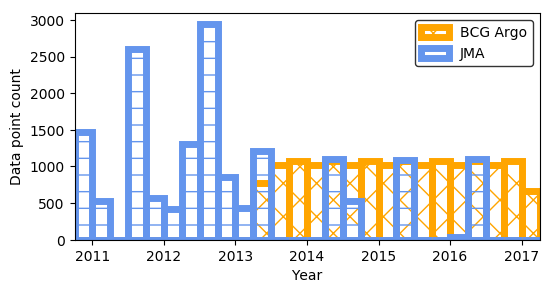

In [72]:
#sampling-date (seasonal) analysis. 
#The code for this is from the work of Corday and Austin!!
data_Kuro_noNO3 = data_BGC

fig, (ax) =  plt.subplots(1, 1, figsize = (6, 3), dpi = 100)

jma_dayssince = ((data.year - 1900)*364.75) + (data.month*(364.75/12)) + data.day

bins = np.arange(2010,2018,0.25)

plt.hist(1900+data_Kuro_noNO3['Days since 1/1/1900']/364.75, edgecolor = "orange", lw = 5, facecolor = "None", bins = bins, hatch = 'X')
plt.hist(1900+jma_dayssince/364.75, edgecolor = "cornflowerblue", facecolor = "None", lw = 5, bins = bins, hatch = '-')

ax.set_xlabel('Year')
ax.set_ylabel('Data point count')
ax.legend(('BCG Argo', 'JMA'), edgecolor = 'k', loc = 'upper right')
ax.set_xticks(np.arange(2010,2019,1))
ax.set_xlim([2010.75,2017.25])

# Section 2, model testing and best fit analysis using entire dataset

Start of model testing, and comparison to find the best fit model for this dataset using KNN.

We chose to use temperature and salinity as variables to model nitrate from.

In [73]:
#import the jma nitrate file, then get columns I want for training
infile = 'jma_nitrate.csv'
nitratefile = pd.read_csv(infile,sep=(','))
nitratefilefiltered = nitratefile[nitratefile.nitrate>0]
X = nitratefilefiltered[["sal","theta"]]
y = nitratefilefiltered[["nitrate"]]
print(np.shape(X))
print(np.shape(y))


#split data set to train/test 20/80 split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

(15574, 2)
(15574, 1)


In [74]:
# generate the data
import matplotlib.pyplot as plt
import random


# pick model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
    
#run KNN with K neighbors ranging from 1-15, calculating 
#r2 and RMSE to find the best fit model
results = []
for n in range(1,16,1):
    res = []
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, y_train)
    #print ('Neighbors = %s\n' % (int(n)))
    # compute the R^2 score
    accuracyscore = model.score(X_train,y_train)
    #print("Training R^2 score: {0:.2f}\n".format(model.score(X_train,y_train)))
    # plot the model together with the data
    xfit = X_test
    yfit = model.predict(xfit)
    #print("Testing R^2 score: {0:.2f}\n".format(model.score(xfit,yfit)))
    rmse = sqrt(mean_squared_error(y_test, yfit))
    #print("RMSE = %s \n" % (rmse))
    res = [n,accuracyscore,rmse]
    results.append(res)


Model and output is saved in the cell above and printed in table format in the cell below.

In [76]:
#Make list into array to plot nicely, in order to look at all of the 
#results

myarray = np.asarray(results)

#make a dataframe with each column named for ploting
data = pd.DataFrame({'Kneighbors': myarray[:,0], 'AccScore': myarray[:,1], 'RMSE': myarray[:,2]})
data


,AccScore,Kneighbors,RMSE
0,0.999911,1.0,2.605836
1,0.992724,2.0,2.430276
2,0.989437,3.0,2.320553
3,0.987749,4.0,2.294769
4,0.986243,5.0,2.265839
5,0.985364,6.0,2.217849
6,0.984661,7.0,2.213640
7,0.984078,8.0,2.195321
8,0.983682,9.0,2.202208
9,0.983316,10.0,2.193945


Looking at the table above we see that the best fit model is using 10 K neighbors. The accuracy is high and RMSE is lowest.

In [78]:
#Run best fit model, and display results
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)
print ('Neighbors = %s\n' % (10))
    # compute the R^2 score
accuracyscore = model.score(X_train,y_train)
print("Training R^2 score: {0:.2f}\n".format(model.score(X_train,y_train)))
    # plot the model together with the data
xfit = X_test
yfit = model.predict(xfit)
print("Testing R^2 score: {0:.2f}\n".format(model.score(xfit,yfit)))
rmse = sqrt(mean_squared_error(y_test, yfit))
print("RMSE = %s \n" % (rmse))

Neighbors = 10

Training R^2 score: 0.98

Testing R^2 score: 1.00

RMSE = 2.19394523563 



# We can delete or get rid of the next two graphs. Only really showed us that the training/testing worked. The graphs just look cool. Do we want to mention here that it looks like the model output doesn't results in many outliers using temperature and salinity as input variables?

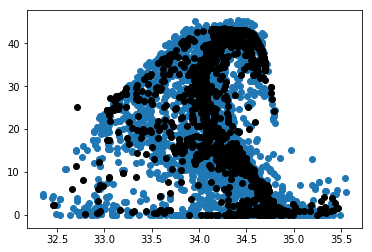

In [79]:
#Plot salinity vs. nitrate predicted
plt.scatter(X_train[["sal"]],y_train)
plt.scatter(xfit[["sal"]], yfit,c = 'k')

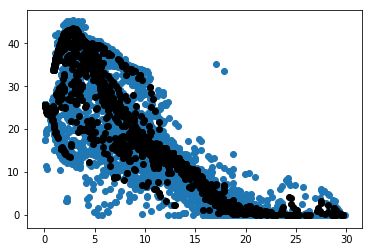

In [80]:
#Plot temperature vs. nitrate predicted
plt.scatter(X_train[["theta"]],y_train)
plt.scatter(xfit[["theta"]], yfit,c = 'k')

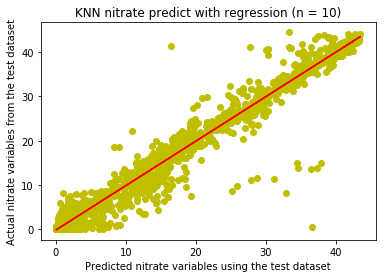

r2 = 0.999959669685455 

RMSE = 0.096728040609 



In [83]:
#Plot predicted nitrate from test compared to actual nitrate from test
#this is using the best fit model decided above
from sklearn.linear_model import LinearRegression
plt.scatter(yfit,y_test,color = 'y')
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(yfit, y_test)  # perform linear regression
Y_pred = linear_regressor.predict(yfit)  # make predictions
plt.plot(yfit, Y_pred, color='red')
plt.xlabel("Predicted nitrate variables using the test dataset")
plt.ylabel("Actual nitrate variables from the test dataset")
plt.title("KNN nitrate predict with regression (n = 10)")
plt.show()
r2 = r2_score(yfit, Y_pred)
print("r2 = %s \n" % (r2))
rmse = sqrt(mean_squared_error(yfit, Y_pred))
print("RMSE = %s \n" % (rmse))

# Discussion on above plot? We do have some outliers but r2/RMSE look great.

In [133]:
#File using all of data for training
#nitratefile

infilekuro = 'kuro_BGCargo_noNO3.csv'
nitratefilekuro = pd.read_csv(infilekuro,sep=(','))
X = nitratefilekuro[["SALINITY[PSS]","TEMPERATURE[C]"]]

infilekurowithnitrate = 'kuro_BGCargo_NO3.csv'
realNO3file = pd.read_csv(infilekurowithnitrate,sep=(','))
NO3real = realNO3file[["NITRATE[uMOL/KG]"]]



Here we are filtering the argo data, so that we don't try and predict values that are 
below 0. From the argo dataset, we get rid of any nitrate values (and associated temp/salinity values) that are less than 0. Such that our model doesn't try and predict nitrate values that are less than 0.

In [135]:
Xconcat = pd.concat([X, NO3real], axis=1)
#print Xconcat.shape
NO3filter =  Xconcat['NITRATE[uMOL/KG]']>=0
#print(NO3filter.head())
AllNo3filtered = Xconcat[NO3filter]
X = AllNo3filtered[["SALINITY[PSS]","TEMPERATURE[C]"]]
NO3real = AllNo3filtered[["NITRATE[uMOL/KG]"]]
#print AllNo3filtered.shape
#NO3filter

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
         ... 
16093    True
16094    True
16095    True
16096    True
16097    True
16098    True
16099    True
16100    True
16101    True
16102    True
16103    True
16104    True
16105    True
16106    True
16107    True
16108    True
16109    True
16110    True
16111    True
16112    True
16113    True
16114    True
16115    True
16116    True
16118    True
16122    True
16129    True
16133    True
16134    True
16135    True
Name: NITRATE[uMOL/KG], Length: 14129, dtype: bool

In [87]:
#Predict the argo nitrate data using filtered Salinity/Temperature data from the argo dataset
NO3predicted = model.predict(X)
NO3predicted

array([[42.054],
       [41.457],
       [41.446],
       ...,
       [40.26 ],
       [39.383],
       [38.218]])

Plot the predicted argo nitrate data with the actual filtered argo nitrate data.

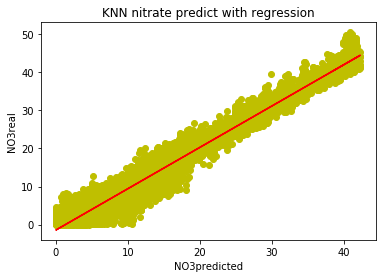

r2 = 0.9541032567321227 

RMSE = 2.56209634876 



In [88]:
#NO3realfilter = NO3real[NO3real.NITRATE[uMOL/KG]>0]
ax = plt.scatter(NO3predicted,NO3real,color = 'y')
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(NO3predicted, NO3real)  # perform linear regression
Y_pred = linear_regressor.predict(NO3predicted)  # make predictions
plt.plot(NO3predicted, Y_pred, color='red')
plt.xlabel("NO3predicted")
plt.ylabel("NO3real")
plt.title("KNN nitrate predict with regression")
plt.show()
r2 = r2_score(NO3predicted, NO3real)
print("r2 = %s \n" % (r2))
#text(50, 5, r2, fontsize=12)
rmse = sqrt(mean_squared_error(NO3predicted, NO3real))
print("RMSE = %s \n" % (rmse))

# Discussion about variability with low NO3 values?

# Section 3, Zoom in on JMA data to only train the model on data that corresponds to the same geographic region as the ARGO dataset is collected from

In [94]:
#Some variable names are being reloaded in order to combine scripts from each member of the group.

#import JMA data
#infile='C:/Users/a_mac/Box Sync/1 ODU semestres/8 spring 2020/classes/Sophies Advanced data science techniques/problem_set_3/jma_nitrate.csv'
data=nitratefile
#data

#import BCGargo data
#infile_Kuro_noNO3='C:/Users/a_mac/Box Sync/1 ODU semestres/8 spring 2020/classes/Sophies Advanced data science techniques/problem_set_3/kuro_BGCargo_noNO3.csv'
data_Kuro_noNO3=nitratefilekuro
#data_Kuro_noNO3

# Compare the geographical extent, in order to zoom in on a general geographic area from the JMA that generally overlaps with the ARGO dataset

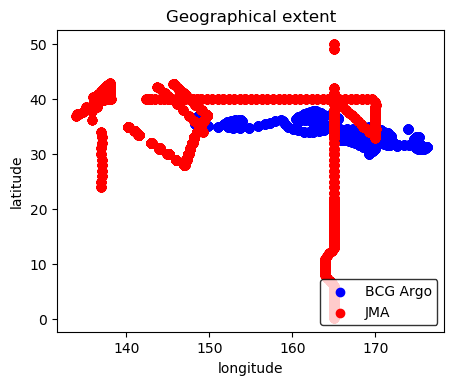

In [95]:
fig, (ax) =  plt.subplots(1, 1, figsize = (5, 4), dpi = 100)
plt.scatter(data_Kuro_noNO3[["LON"]],data_Kuro_noNO3[["LAT"]],color='blue')
plt.scatter(data.lon,data.lat, color='red')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geographical extent')
ax.legend(('BCG Argo', 'JMA'), edgecolor = 'k', loc = 'lower right')

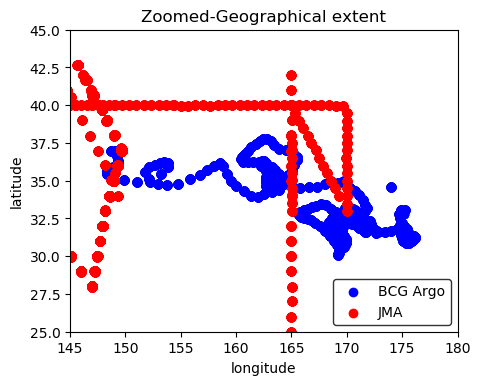

In [96]:
fig, (ax) =  plt.subplots(1, 1, figsize = (5, 4), dpi = 100)
plt.scatter(data_Kuro_noNO3[["LON"]],data_Kuro_noNO3[["LAT"]],color='blue')
plt.scatter(data.lon,data.lat, color='red')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed-Geographical extent')
plt.ylim((25,45))
plt.xlim((145,180))
ax.legend(('BCG Argo', 'JMA'), edgecolor = 'k', loc = 'lower right')

# Describe similarities and highlight differences.

Just from the geographic extend, we can see that the distribution of JMA samples is considerably higher than that of BCG ARGO samples. However big this despair, for this and other variables, there is some overlap in the sampled region, depths, and seasons. 
The geographical extent overlaps in the region between the ~30 to ~40° of latitude and ~150 to ~175° of longitude. The density of sampling points is higher in that region for BCG Argo.
BCG samples range from the surface to 6,000m depth, but JMA samples go only to 1,000m. Therefore, this should be another major consideration during the building and testing of the model.
Given the regions and depth in which samples were collected, it was to be expected that water masses will be different. Although isopycnals are not shown, it is clear from the plot that different water masses have been sampling in either of the campaigns (with some overlap).
Most of the JMA samples were collected from 2011 to 2013, with fewer samples collected until 2017. In the other hand, BCG sampling focusses on that last period of time.

BUILD your model to the BGC Argo data to estimate nitrate concentrations based on your input variables (e.g. temperature, salinity, etc…).

This is using zoomed in data from the JMA dataset. 

In [98]:
# change here the limits (LAT/LON) for the region you want to work with
longitude_lower_lim=168
longitude_upper_lim=172
latitude_lower_lim=30
latitude_upper_lim=41

In [99]:
# create filter(s) to saparate samples from more localized Lat/Long regions
cruise=data[(data.lon>longitude_lower_lim)&(data.lon<longitude_upper_lim)&(data.lat>latitude_lower_lim)&(data.lat<latitude_upper_lim)]
#cruise

In [100]:
# associate spatial and nitrate filters
filter_NO3_cruise = cruise[cruise.nitrate>0]

Text(0.5,1,'Nitrate concentration profile')

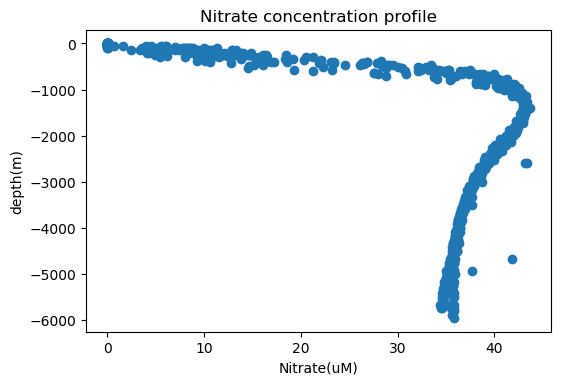

In [103]:
# plot the new NO3 profile for the given region
fig, (ax) =  plt.subplots(1, 1, dpi = 100)
plt.scatter(filter_NO3_cruise.nitrate,-filter_NO3_cruise.depth)
ax.set_xlabel('Nitrate(uM)')
ax.set_ylabel('depth(m)')
ax.set_title('Nitrate concentration profile')

In [104]:
#define the sets of data to be used
X=filter_NO3_cruise[["sal","theta"]]
y=filter_NO3_cruise[["nitrate"]]

In [105]:
#print the shape of the sets of data to corroborate that they will be useful while building the model
print(np.shape(X))
print(np.shape(y))

(755, 2)
(755, 1)


In [106]:
# Split the data into training/testing sets
# 1) import the fuction
from sklearn.model_selection import train_test_split

In [107]:
# 2) use the fuction 'train_test_split' to define the train and test datasets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [108]:
print(np.shape(X_train))
print(np.shape(y_train))

(604, 2)
(604, 1)


In [109]:
# pick model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
    
results = []
for n in range(1,20,1):
    res = []
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, y_train)
    #print ('Neighbors = %s\n' % (int(n)))
    # compute the R^2 score
    accuracyscore = model.score(X_train,y_train)
    #print("Training R^2 score: {0:.2f}\n".format(model.score(X_train,y_train)))
    # plot the model together with the data
    xfit = X_test
    yfit = model.predict(xfit)
    #print("Testing R^2 score: {0:.2f}\n".format(model.score(xfit,yfit)))
    rmse = sqrt(mean_squared_error(y_test, yfit))
    #print("RMSE = %s \n" % (rmse))
    res = [n,accuracyscore,rmse]
    results.append(res)

In [110]:
myarray = np.asarray(results)

#make a dataframe with each column named for ploting
KNN_test_data = pd.DataFrame({'Kneighbors': myarray[:,0], 'AccScore': myarray[:,1], 'RMSE': myarray[:,2]})
KNN_test_data

,AccScore,Kneighbors,RMSE
0,0.999999,1.0,1.124828
1,0.997822,2.0,0.929003
2,0.996948,3.0,0.942965
3,0.996760,4.0,0.891603
4,0.996550,5.0,0.829498
5,0.996353,6.0,0.831039
6,0.996248,7.0,0.791823
7,0.996193,8.0,0.745891
8,0.996074,9.0,0.774016
9,0.995952,10.0,0.784796


Text(0.5,1,'model performance depending on k-number')

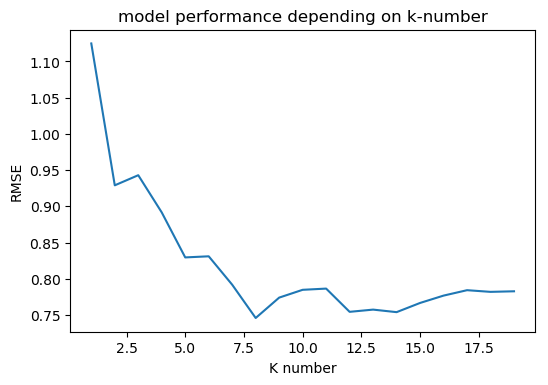

In [111]:
fig, (ax) =  plt.subplots(1, 1, dpi = 100)
plt.plot(myarray[:,0],myarray[:,2])
plt.xlabel('K number')
plt.ylabel('RMSE')
ax.set_title('model performance depending on k-number')

Build a model based on the above analysis (effect of k number)

Choose a number for k: 8
Training R^2 score: 1.00
Testing R^2 score: 1.00


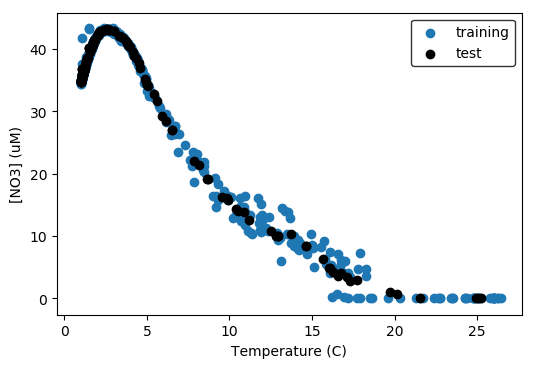

In [119]:
# use the script below to build the model based on KNN. 
# you will have to choose a number for 'k'.

n  = int(input('Choose a number for k: '))

# pick model
model = KNeighborsRegressor(n_neighbors=n)
model.fit(X_train, y_train)

# compute the R^2 score
print("Training R^2 score: {0:.2f}".format(model.score(X_train,y_train)))

# plot the model together with the data
xfit = X_test
yfit = model.predict(xfit)
print("Testing R^2 score: {0:.2f}".format(model.score(xfit,yfit)))

#plt.scatter(X_train[["sal"]],y_train)
fig, (ax) =  plt.subplots(1, 1, dpi = 100)
plt.scatter(X_train[["theta"]],y_train)
plt.scatter(xfit[["theta"]], yfit,c = 'k')
plt.xlabel('Temperature (C)')
plt.ylabel('[NO3] (uM)')
ax.legend(('training', 'test'), edgecolor = 'k', loc = 'upper right')

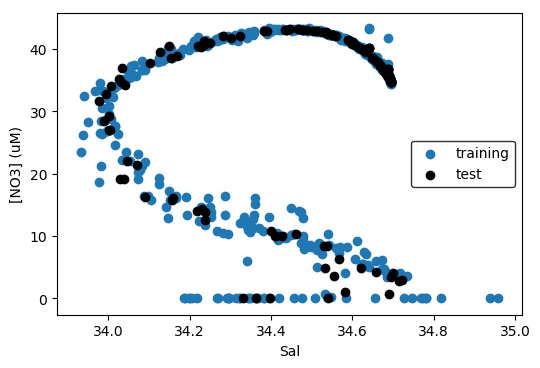

In [120]:
# plot the nitrate predictions vs the other test variable (i.e. salinity)
# and plot the train data to compare with the model

fig, (ax) =  plt.subplots(1, 1, dpi = 100)
plt.scatter(X_train[["sal"]],y_train)
plt.scatter(xfit[["sal"]], yfit,c = 'k')
plt.xlabel('Sal')
plt.ylabel('[NO3] (uM)')
ax.legend(('training', 'test'), edgecolor = 'k', loc = 'center right')

# APPLY your model to the BGC Argo data to estimate nitrate concentrations based on your input variables (e.g. temperature, salinity, etc…).

In [121]:
# create filter(s) to saparate samples from more localized Lat/Long regions
Kuro_noNO3_cruise=data_Kuro_noNO3[(data_Kuro_noNO3.LON>longitude_lower_lim)&(data_Kuro_noNO3.LON<longitude_upper_lim)&(data_Kuro_noNO3.LAT>latitude_lower_lim)&(data_Kuro_noNO3.LAT<latitude_upper_lim)]
#Kuro_noNO3_cruise

In [122]:
# Make your predictions using a KNN model based on salinity and temperature
xkuro = Kuro_noNO3_cruise[["SALINITY[PSS]","TEMPERATURE[C]"]]
predictionsNO3=model.predict(xkuro)
print(np.shape(predictionsNO3))

(6420, 1)


In [140]:
#import the data that contains the actual NO3 values to compare with your predictions
#infile_Kuro_NO3='C:/Users/a_mac/Box Sync/1 ODU semestres/8 spring 2020/classes/Sophies Advanced data science techniques/problem_set_3/kuro_BGCargo_NO3.csv'
data_Kuro_NO3=realNO3file
#data_Kuro_NO3

# Alfonso, do we want to filter out in the cell below nitrate values that are less than 0? I added that, you can take it out if you want. I also made new predictions so we're not trying to predict nitrate that is < 0. Does that make sense? 
# Let me know if you want to keep it as you had it and I'll change it back.

In [144]:
# create filter(s) to saparate samples from more localized Lat/Long regions
Kuro_NO3_cruise=data_Kuro_NO3[(data_Kuro_NO3.LON>longitude_lower_lim)&(data_Kuro_NO3.LON<longitude_upper_lim)&(data_Kuro_NO3.LAT>latitude_lower_lim)&(data_Kuro_NO3.LAT<latitude_upper_lim)]
NO3_filter = Kuro_NO3_cruise['NITRATE[uMOL/KG]']>=0
Kuro_NO3_cruise = Kuro_NO3_cruise[NO3_filter]
#Kuro_NO3_cruise
# Make your predictions using a KNN model based on salinity and temperature
#filtered for LAT/LON and nitrate<0
xkuro = Kuro_NO3_cruise[["SALINITY[PSS]","TEMPERATURE[C]"]]
predictionsNO3=model.predict(xkuro)
print(np.shape(predictionsNO3))

(4955, 1)


In [145]:
#create variables that contain the predicted and real nitrate values
realNO3=Kuro_NO3_cruise[["NITRATE[uMOL/KG]"]]
X=predictionsNO3
y=realNO3

#  Compare the observed BGC Argo nitrate to your predicted values. Report the r 2 score and RMSE (root mean squared error).

('Coefficients: \n', array([[1.07399961]]))
Mean squared error: 3.70
Coefficient of determination: 0.98


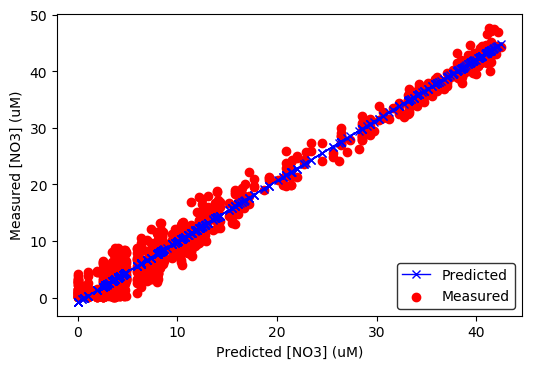

In [146]:
# Split the data into training/testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
fig, (ax) =  plt.subplots(1, 1, dpi = 100)
plt.scatter(X_test, y_test,  color='red')
plt.plot(X_test, y_pred,  '-x', color='blue', linewidth=1)
plt.xlabel('Predicted [NO3] (uM)')
plt.ylabel('Measured [NO3] (uM)')
ax.legend(('Predicted', 'Measured'), edgecolor = 'k', loc = 'lower right')

plt.show()

# Does your model perform consistently well, or are there any noticeable outliers? If there are, identify those data points and suggest reasons why you think that your model performs less well for those points.

The fit of the predicted vs the measured values is better when applying filters to better match the data (i.e. depth, season, geography, etc.). There are still measured values that departure considerably from the predicted line. This is more obvious in the lower end of the nitrate concentrations. These values are commonly associated to the upper layers, where nutrient uptakes occur. 

The dynamics of the ocean surface are variable depending not only on temperature and salinity, but in a set of variables with keeps growing with continuous research (i.e. mixotrophy, light attenuation, phytoplankton diversity, food chain interactions, availability of micro and macro nutrients, etc.). A more complex model that evaluates and adds the relevance of more nitrate controlling variables should be considered for further research/problem sets.

# Section 4, how do the best fit models using entire JMA dataset and zoomed in JMA dataset compare when used to predict nitrate values for the ARGO dataset?

Model trained using entire JMA dataset:
Mean squared error: 2.56
Coefficient of determination : 0.95

Model trained using zoomed in JMA dataset:
Mean squared error: 3.70
Coefficient of determination: 0.98

We can see that using the zoomed in dataset the accuracy is better but the RMSE is higher. Both are good models but the error is less in the model trained using the entire JMA dataset.